## 3.2. GLM Activation: Task-based fMRI analysis
This notebook explores how to map brain activity by correlating BOLD signal changes with specific experimental tasks using the General Linear Model (GLM). The **General Linear Model** is the workhorse of fMRI analysis. 

It models the measured BOLD signal as a linear combination of predictors:

$Y = X\beta + \epsilon$

Where:
- **Y**: Observed BOLD signal (what we measured)
- **X**: Design matrix (what we expect based on the experiment)
- **β**: Beta weights (effect sizes - what we want to estimate)
- **ε**: Residual error (unexplained variance)

**Key Concepts**:

1. **Design Matrix**: Building the temporal model of the experiment.
2. **Hemodynamic Response Function (HRF)**: Account for the delay in the blood-oxygen response.
3. **Contrasts**: Subtracting brain activity states to isolate specific functions.

**Resources**:
- https://www.youtube.com/watch?v=qnjiJ41cryQ 


In [88]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from nilearn import datasets, plotting
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_glass_brain
from nilearn import image

### 1. Load Preprocessed Data

For this GLM analysis, we use the OpenNeuro ds000117 dataset. This is a multimodal dataset (fMRI, EEG, and MEG) famously used to study the neural correlates of face processing.

**Experimental Task**: In this experiment, participants viewed three types of visual stimuli:
1. **Famous Faces**: Familiar faces (e.g., politicians, actors).
2. **Unfamiliar Faces**: Faces the participant had never seen before.
3. **Scrambled Faces**: Images where the face pixels were randomized, preserving the low-level visual properties (luminance, contrast) but removing the "face" structure.


In [55]:
repo_root = Path("./").resolve().parents[1]
target_dir = repo_root / "datasets" / "fmri_faces"
target_dir.mkdir(parents=True, exist_ok=True)

In [57]:
data = datasets.fetch_spm_multimodal_fmri(data_dir=str(target_dir))

[wrapper] Dataset found in /Users/yibeisita/Documents/neuro-ai-playground/datasets/fmri_faces/spm_multimodal_fmri


In [58]:
print(dir(data))
print(data.keys())

['anat', 'description', 'events1', 'events2', 'func1', 'func2', 'slice_order', 't_r', 'trials_ses1', 'trials_ses2']
dict_keys(['slice_order', 'func1', 'trials_ses1', 'events1', 'func2', 'trials_ses2', 'events2', 'anat', 'description', 't_r'])


This dataset uses an older format where **each timepoint is a separate file** (390 files total), rather than one 4D file. We need to combine them:
- `concat_imgs()` - Combines 390 separate 3D images into one 4D time series
- `auto_resample=True` - Automatically corrects for small head movements between scans

Modern datasets usually come as a single 4D file, but this teaches you to handle legacy data formats!

In [65]:
# Concatenate all volumes, allowing automatic resampling for slight differences
func_img = image.concat_imgs(data.func1, auto_resample=True)
print(f"4D Functional image shape: {func_img.shape}")

/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_3879/3228534598.py:2: UserWarning: Affine is different across subjects. Realignment on first subject affine forced
  func_img = image.concat_imgs(data.func1, auto_resample=True)
/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/joblib/memory.py:326: UserWarning: Casting data from int16 to float32
  return self.func(*args, **kwargs)
/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_3879/3228534598.py:2: UserWarning: Affine is different across subjects. Realignment on first subject affine forced
  func_img = image.concat_imgs(data.func1, auto_resample=True)
/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/joblib/memory.py:326: UserWarning: Casting data from int16 to float32
  return self.func(*args, **kwargs)
/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_3879/3228534598.py:2: UserWarning: Affine is different across subjects. Realignment on firs

4D Functional image shape: (64, 64, 32, 390)


/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_3879/3228534598.py:2: UserWarning: Affine is different across subjects. Realignment on first subject affine forced
  func_img = image.concat_imgs(data.func1, auto_resample=True)
/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/joblib/memory.py:326: UserWarning: Casting data from int16 to float32
  return self.func(*args, **kwargs)
/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_3879/3228534598.py:2: UserWarning: Affine is different across subjects. Realignment on first subject affine forced
  func_img = image.concat_imgs(data.func1, auto_resample=True)
/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/joblib/memory.py:326: UserWarning: Casting data from int16 to float32
  return self.func(*args, **kwargs)
/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_3879/3228534598.py:2: UserWarning: Affine is different across subjects. Realignment on firs

In [62]:
events_file = data.events1   # Timing/Conditions for first run
anat_img = data.anat         # Structural image

In [64]:
events = pd.read_table(events_file)

print(f"Conditions found: {events['trial_type'].unique()}")
print(f"Repetition Time (TR): {data.t_r}s")

events.head()

Conditions found: ['faces' 'scrambled']
Repetition Time (TR): 2s


,trial_type,onset,duration
0,faces,15.723,1.0
1,faces,24.788,1.0
2,faces,88.238,1.0
3,faces,115.426,1.0
4,faces,124.487,1.0


### 2. Creating the Design Metrics
The design matrix represents our hypothesis: "When was the subject looking at a face?" It maps when a task happened to what we expect to see in the brain.
- Brighter / warmer colors → larger positive values
- Darker / cooler colors → smaller or negative values

**HRF (Hemodynamic Response Function)**: fMRI doesn't measure neural activity directly - it measures blood flow changes. When neurons activate, blood flow increases slowly (peaking ~5 seconds later) then returns to baseline. The HRF is like a "blur filter" that converts sharp experimental events into the sluggish blood flow response we actually measure.

In [66]:
tr = 2.0  # Time between scans (in seconds)
n_scans = func_img.shape[-1]  # Get actual number of scans
frame_times = np.arange(n_scans) * tr

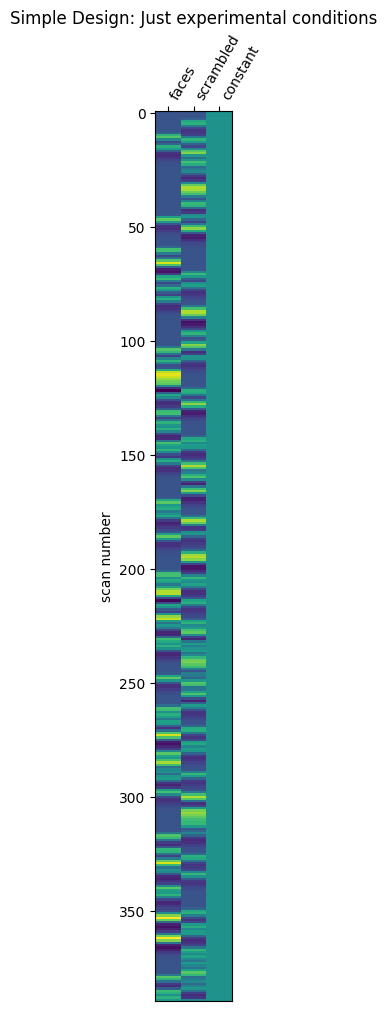

In [67]:
# Just the experimental conditions
simple_design = make_first_level_design_matrix(
    frame_times,
    events,
    hrf_model='glover',
    drift_model=None,
)

plot_design_matrix(simple_design)
plt.title('Simple Design: Just experimental conditions')
plt.show()

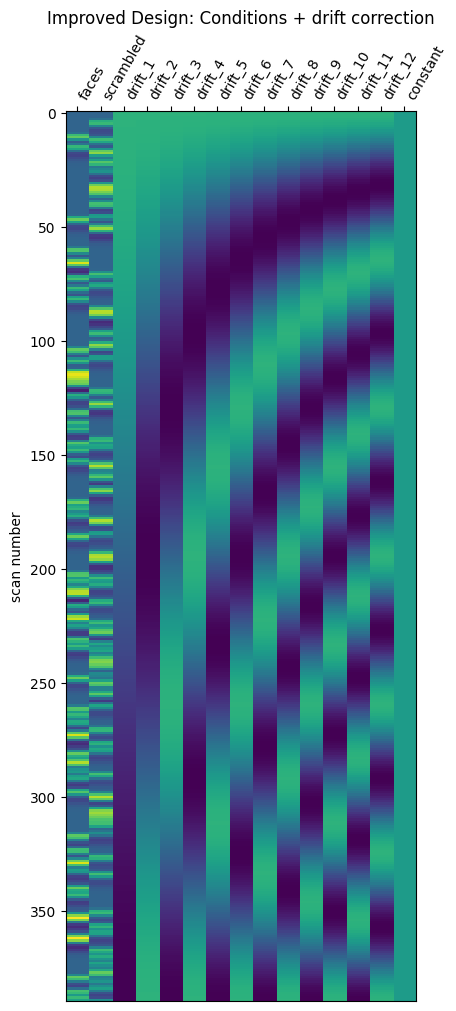

In [68]:
# Add cosine drift regressors to remove slow signal changes and high pass filter
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    hrf_model='glover', # Models the brain's hemodynamic response
    drift_model='cosine',  # Removes slow drifts in the signal
    high_pass=1./128,  # Filter out very slow fluctuations (>128s)
)

plot_design_matrix(design_matrix)
plt.title('Improved Design: Conditions + drift correction')
plt.show()

In [69]:
print(f"\nDesign matrix shape: {design_matrix.shape}")
print(f"({n_scans} time points × {design_matrix.shape[1]} predictors)")


Design matrix shape: (390, 15)
(390 time points × 15 predictors)


### 4. Fitting the GLM
We apply the model to every voxel in the brain to find where the BOLD signal matches our design matrix.

- **AR1 Noise Model**: fMRI scans are temporally correlated (each scan resembles the previous one). The `'ar1'` model accounts for this autocorrelation, preventing false positives.
- **SNR (Signal-to-Noise Ratio)**: True brain signal divided by random noise. Higher = better. Spatial smoothing (5mm) increases SNR by averaging nearby voxels - signal adds up while random noise cancels out.
- **Spatial Smoothing (`smoothing_fwhm=5.0`)**: We blur the brain images slightly (5mm Gaussian kernel) to increase SNR. When we average neighboring voxels, true signals add up while random noise cancels out - like how averaging multiple photos reduces graininess.

In [70]:
# Fit the GLM (General Linear Model) to estimate brain responses
fmri_glm = FirstLevelModel(
    t_r=tr,
    noise_model='ar1',  # Models temporal autocorrelation
    standardize=False,
    hrf_model=None,  # Already applied in design_matrix
    drift_model=None,  # Already in design_matrix
    high_pass=None,  # Already in design_matrix
    smoothing_fwhm=5.0,  # Spatial smoothing in mm (increases SNR)
)

In [71]:
print(f"Functional image shape: {func_img.shape}")
print(f"Number of scans: {func_img.shape[-1]}")

Functional image shape: (64, 64, 32, 390)
Number of scans: 390


In [72]:
fmri_glm = fmri_glm.fit(func_img, design_matrices=design_matrix)

/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_3879/1654823524.py:1: UserWarning: If design matrices are supplied, [drift_model, high_pass, hrf_model, t_r] will be ignored.
  fmri_glm = fmri_glm.fit(func_img, design_matrices=design_matrix)


### 5. Statistical Contrast & Visualization


A **contrast** specifies which brain activity we want to test. It's a set of weights applied to our design matrix columns.

**Example contrasts:**
- `[1, 0, 0, ...]` - Test the first condition vs baseline
- `[1, -1, 0, ...]` - Compare condition 1 vs condition 2
- `[1, 1, 0, ...]` - Average of conditions 1 and 2

**What is a Z-score?**

The z-score tells us how unusual the activation is at each brain location:
- **z > 3.1** (p < 0.001) - Strong evidence of activation
- **z = 0** - No effect
- **z < -3.1** - Deactivation (brain activity decreases)

Higher z-scores = stronger statistical evidence that the brain region responds to your experimental condition.

In [94]:
print("Available conditions:", design_matrix.columns.tolist())

Available conditions: ['faces', 'scrambled', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9', 'drift_10', 'drift_11', 'drift_12', 'constant']


In [115]:
# Create a contrast vector (one weight per column in design matrix)
conditions = design_matrix.columns
contrast_matrix = np.zeros(len(conditions))
print(contrast_matrix)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [116]:
# Set faces condition to 1 (look for positive activation)
# Find the index of the faces column
faces_idx = [i for i, col in enumerate(conditions) if 'faces' in col.lower()][0]
contrast_matrix[faces_idx] = 1
print(contrast_matrix)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [117]:
print("Testing contrast for:", conditions[0])
print("Contrast vector:", contrast_matrix)

Testing contrast for: faces
Contrast vector: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [118]:
# This calculates a z-score for each brain voxel
# z-score tells us: "How strongly is this voxel activated during our condition?"
z_map = fmri_glm.compute_contrast(contrast_matrix, output_type='z_score')

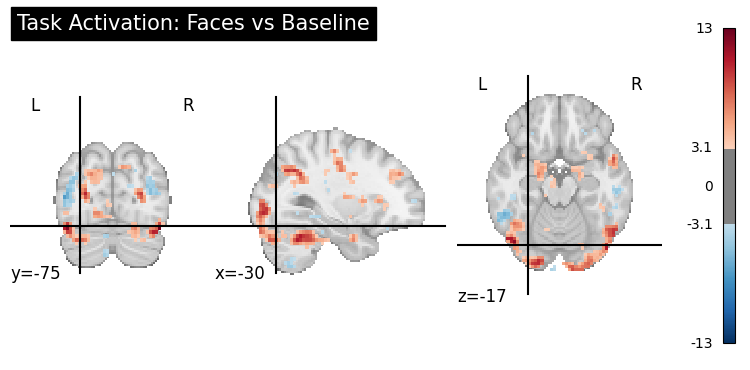

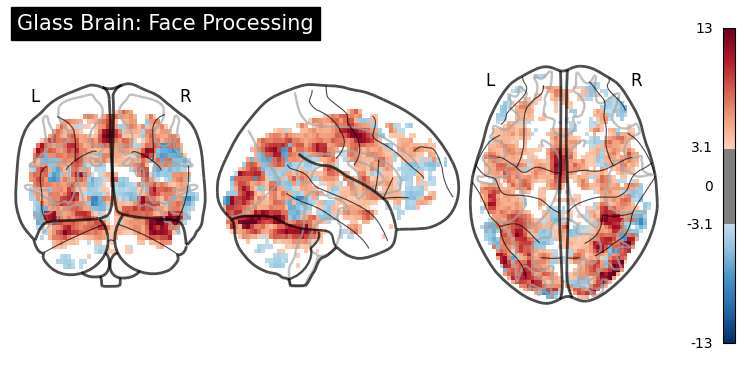

In [119]:
plot_stat_map(
    z_map, 
    threshold=3.1,  # Only show voxels with z-score > 3.1 (strong evidence of activation)
    display_mode='ortho',  # Show three slice views: sagittal, coronal, axial
    colorbar=True, 
    title='Task Activation: Faces vs Baseline'
)

plotting.plot_glass_brain(
    z_map, 
    threshold=3.1,  # Only show strong activations
    colorbar=True, 
    plot_abs=False,
    title='Glass Brain: Face Processing'
)

plt.show()